In [1]:
import pandas as pd 
pd.options.mode.chained_assignment = None 
import numpy as np 
import re 
import nltk 

from gensim.models import word2vec 
from gensim.models.word2vec import LineSentence

from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
false_data = pd.read_csv('fakedata.csv').sample(5000, replace = True, random_state = 23)
true_data = pd.read_csv('realdata.csv').sample(5000, replace = True, random_state = 23)

In [3]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('',val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS: 
            sentence.remove(word)
    
    sentence = " ".join(sentence)
    return sentence 

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = false_data.dropna(how= "any")
    
    for col in ['Headline']: 
        data[col] = data[col].apply(clean_sentence)
    return data 

false_data = clean_dataframe(false_data)
false_data.head(5)


,Unnamed: 0,Unnamed: 0.1,Title,Article,Headline,Title_URL,Image,Facebook_likes,Facebook_comments,Facebook_shares,Comment_replies,results
595,828,828,Fox News,The Biden administration pulled the plug on bo...,border county sheriff says sinaloa cartel brin...,https://www.facebook.com/FoxNews/?__cft__[0]=A...,https://external-sjc3-1.xx.fbcdn.net/safe_imag...,68000.0,43000.0,15000.0,0,'FAKE'
742,1087,44,Conservative Post,Even Liberal Media Fed Up With Biden Administr...,even liberal media fed biden administration la...,https://www.facebook.com/heyconservativepost/?...,https://l.facebook.com/l.php?u=https%3A%2F%2Fc...,433.0,299.0,2800.0,0,'FAKE'
1064,1454,411,BBC,This 'patch of green' has always been importan...,patch green always important neha shes fightin...,https://www.facebook.com/bbc/?hc_ref=ARTPg1uVP...,https://www.facebook.com/bbc/?ref=nf&hc_ref=AR...,973.0,27.0,6200.0,0,'FAKE'
950,1334,291,Conservative Post,Tax paying Americans are being forced to pay f...,house covid bill includes 100 million controve...,https://www.facebook.com/heyconservativepost/?...,https://l.facebook.com/l.php?u=https%3A%2F%2Fc...,101.0,647.0,145.0,0,'FAKE'
31,51,51,CNN,The US Border Patrol has detained more than 11...,border patrol detained unaccompanied minors ma...,https://www.facebook.com/cnn/?__cft__[0]=AZXpa...,https://external-sjc3-1.xx.fbcdn.net/safe_imag...,617.0,1200.0,103.0,57,'FAKE'


In [4]:
true_data = clean_dataframe(true_data)

In [5]:
def build_corpus(data):
    corpus = []
    for col in ['Headline']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
    return corpus 

corpus = build_corpus(false_data)
print(len(corpus))

4327


In [6]:
model = word2vec.Word2Vec(corpus, size=1000, window=20, min_count=5, workers=4)

In [7]:
true_corpus = build_corpus(true_data)
print(len(true_corpus))

4327


In [8]:
model.save("word2vecmodel")

In [9]:
model_true = word2vec.Word2Vec(true_corpus, size=999, window=15, min_count=6, workers=4)

In [10]:
model_true.save("word2vecmodel_true")

In [11]:
def tsne_plot(model):
    labels = []
    tokens = []
    
    for word in model.wv.vocab: 
        tokens.append(model[word])
        labels.append(word)
     
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values: 
        x.append(value[0])
        y.append(value[1])
    
    plt.figure(figsize=(16,16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i],y[i]),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
        if i >100:
            break 
    plt.show() 
      

<ipython-input-11-edc323fda562>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


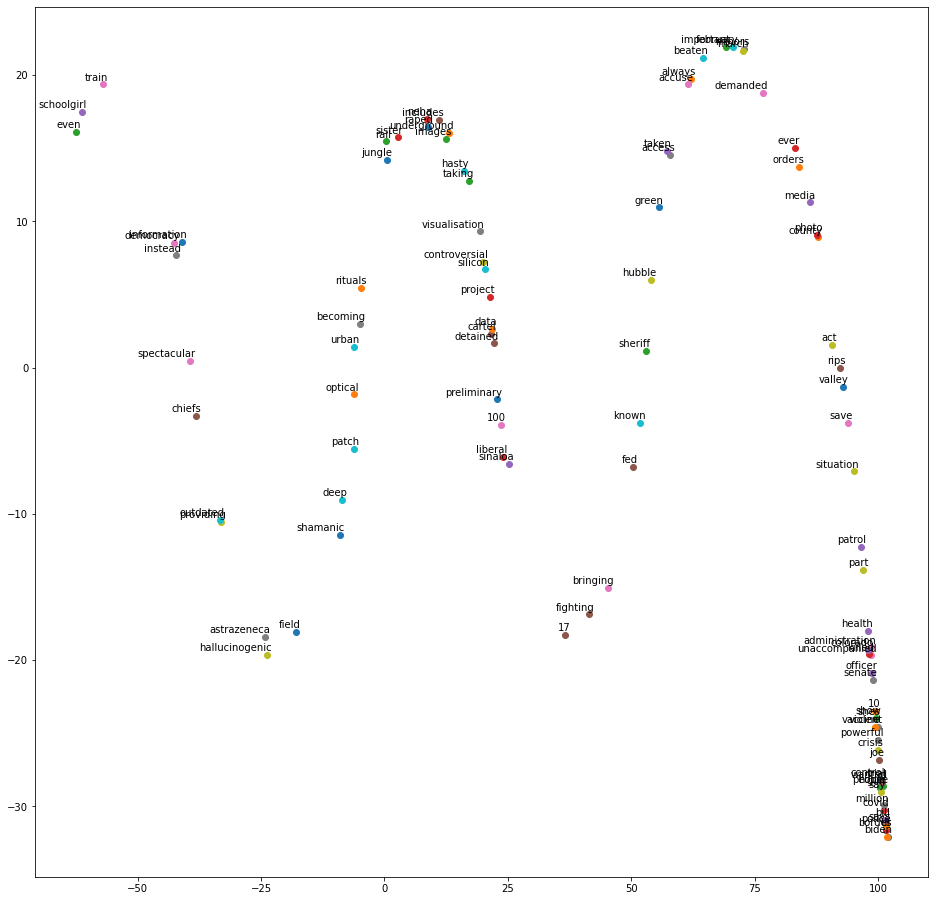

<Figure size 432x288 with 0 Axes>

In [12]:
tsne_plot(model)
plt.savefig('../WordCloud/TSNE_fake.png')

<ipython-input-11-edc323fda562>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


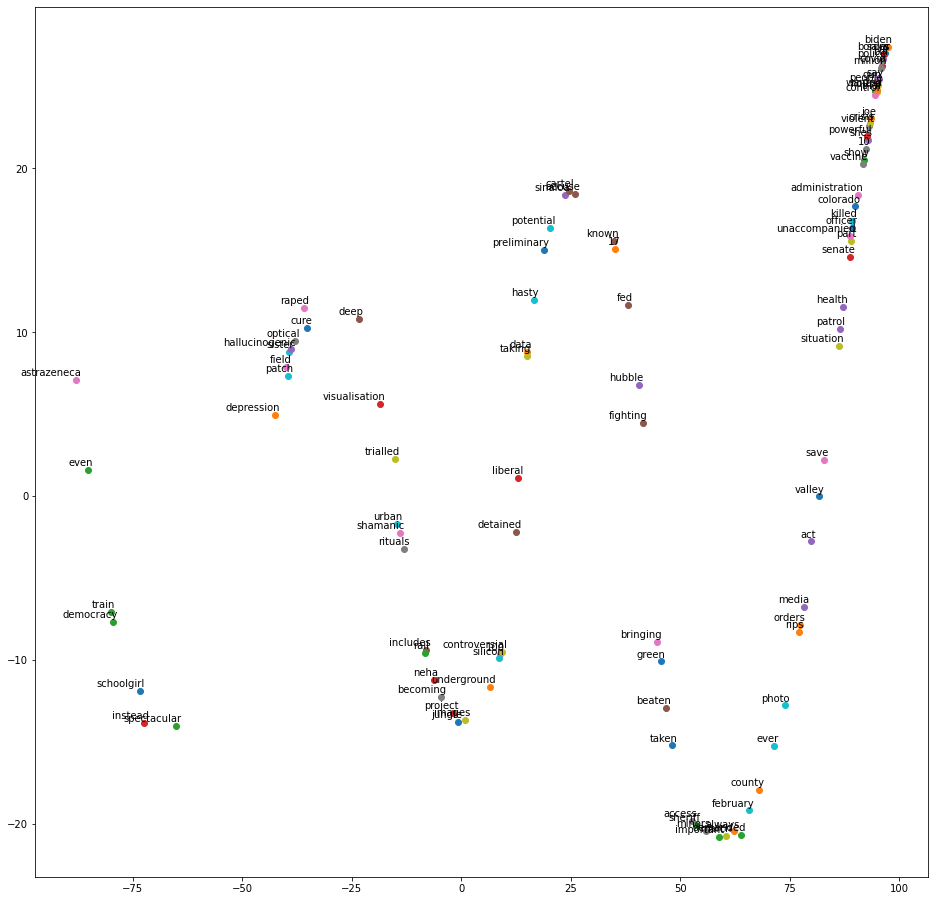

<Figure size 432x288 with 0 Axes>

In [13]:
tsne_plot(model_true)
plt.savefig('../WordCloud/TSNE_true.png')

In [14]:
model.most_similar('trump')

<ipython-input-14-d253bc5c5242>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('trump')


[('biden', 0.9999827146530151),
 ('says', 0.9999791979789734),
 ('', 0.9999781250953674),
 ('us', 0.9999768733978271),
 ('new', 0.9999737739562988),
 ('border', 0.9999710917472839),
 ('first', 0.9999673366546631),
 ('police', 0.9999671578407288),
 ('bill', 0.9999669790267944),
 ('covid', 0.9999653100967407)]

In [15]:
model.most_similar('covid')

<ipython-input-15-2f9095781842>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('covid')


[('', 0.9999728202819824),
 ('biden', 0.9999703168869019),
 ('new', 0.9999680519104004),
 ('trump', 0.9999653100967407),
 ('says', 0.9999640583992004),
 ('us', 0.9999639987945557),
 ('bill', 0.9999635219573975),
 ('million', 0.999961256980896),
 ('first', 0.9999597668647766),
 ('police', 0.9999596476554871)]

In [16]:
model.most_similar('democrat')

<ipython-input-16-de901d6125a9>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('democrat')


[('bill', 0.9940807819366455),
 ('could', 0.9940787553787231),
 ('law', 0.9940764904022217),
 ('americans', 0.9940747022628784),
 ('trump', 0.994072675704956),
 ('families', 0.9940714836120605),
 ('fight', 0.9940672516822815),
 ('', 0.9940640330314636),
 ('american', 0.9940631985664368),
 ('part', 0.9940627813339233)]